# Household Energy Consumption Analysis and Forecasting

This notebook helps EnergySmart analyze residential energy consumption patterns and develop a forecasting system to predict daily and weekly energy usage. Additionally, insights and recommendations are provided to optimize energy usage and reduce electricity bills.

### Dataset
The dataset used is the 'Household Electric Power Consumption' dataset available at [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption).

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import euclidean
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv('./Datasets/household_power_consumption.txt', sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['?'], index_col='datetime')
print(df.head())

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

## 1. Data Preparation and Time Series Analysis

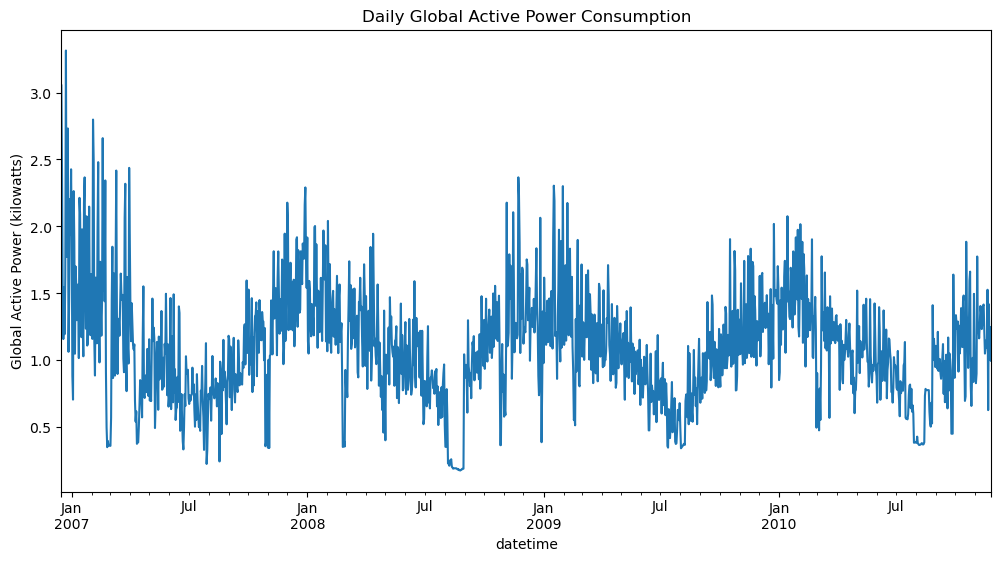

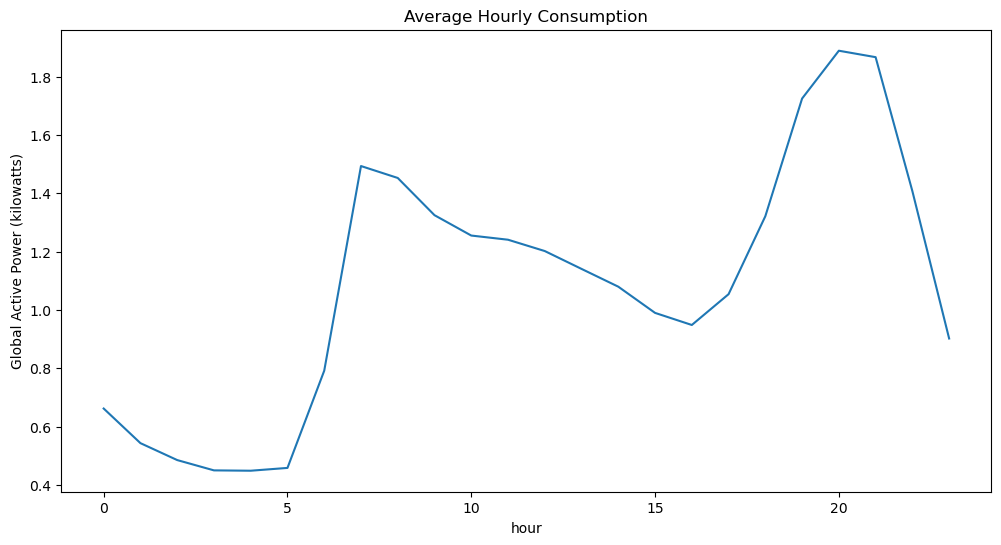

In [3]:
# Resample data to hourly and daily aggregates
df_hourly = df.resample('H').mean()
df_daily = df.resample('D').mean()

# Handle missing values using forward fill
df_hourly.fillna(method='ffill', inplace=True)
df_daily.fillna(method='ffill', inplace=True)

# Create temporal features
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day'] = df_hourly.index.day
df_hourly['week'] = df_hourly.index.isocalendar().week
df_hourly['month'] = df_hourly.index.month
df_hourly['season'] = df_hourly['month'] % 12 // 3 + 1

# Visualize consumption patterns
plt.figure(figsize=(12, 6))
df_daily['Global_active_power'].plot(title='Daily Global Active Power Consumption')
plt.ylabel('Global Active Power (kilowatts)')
plt.show()

plt.figure(figsize=(12, 6))
df_hourly.groupby('hour')['Global_active_power'].mean().plot(title='Average Hourly Consumption')
plt.ylabel('Global Active Power (kilowatts)')
plt.show()

## 2. Energy Usage Pattern Discovery

         Global_active_power  Global_reactive_power     Voltage  \
cluster                                                           
0                   2.619682               0.160604  238.923306   
1                   1.263812               0.121848  240.542712   
2                   0.359119               0.110183  241.809295   

         Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
cluster                                                                     
0               11.034951        4.547955        4.633808       13.679641   
1                5.308580        0.847316        0.841139        9.781649   
2                1.587504        0.016558        0.357728        0.965564   

              hour        day       week     month    season  
cluster                                                       
0        14.957744  15.743215  25.374614  6.236958  2.225256  
1        12.703958  15.777450  26.003591  6.390760  2.489706  
2         9.215921  15.783

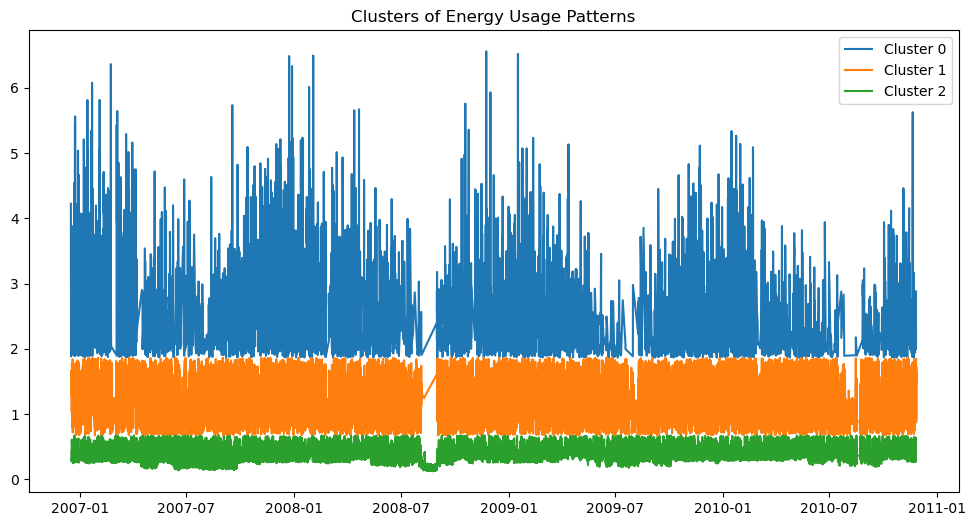

In [4]:
# Apply hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
df_hourly['cluster'] = clustering.fit_predict(df_hourly[['Global_active_power']].dropna())

# Profile clusters
print(df_hourly.groupby('cluster').mean())

# Visualize clusters
plt.figure(figsize=(12, 6))
for cluster in df_hourly['cluster'].unique():
    cluster_data = df_hourly[df_hourly['cluster'] == cluster]
    plt.plot(cluster_data.index, cluster_data['Global_active_power'], label=f'Cluster {cluster}')
plt.legend()
plt.title('Clusters of Energy Usage Patterns')
plt.show()

## 3. Forecasting Model Development

In [5]:
# Create lagged features
df_daily['lag1'] = df_daily['Global_active_power'].shift(1)
df_daily['lag7'] = df_daily['Global_active_power'].shift(7)
df_daily.dropna(inplace=True)

# Split data into train and test sets
X = df_daily[['lag1', 'lag7']]
y = df_daily['Global_active_power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print()

Random Forest:
  MAE: 0.2601
  RMSE: 0.3394
  R²: 0.3713

Gradient Boosting:
  MAE: 0.2371
  RMSE: 0.3192
  R²: 0.4438

XGBoost:
  MAE: 0.2771
  RMSE: 0.3621
  R²: 0.2845



## 4. Feature Engineering and Selection

In [6]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print(f"Explained Variance Ratio: {np.sum(pca.explained_variance_ratio_):.4f}")

# Identify important features using Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
print("Feature Importances:")
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")

Explained Variance Ratio: 1.0000
Feature Importances:
lag1: 0.6193
lag7: 0.3807


## 5. Anomaly Detection

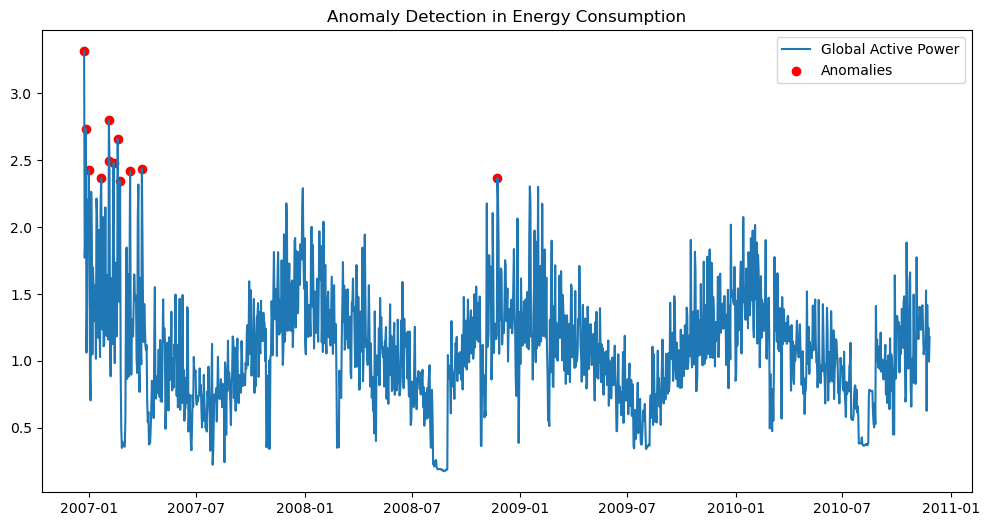

In [7]:
# Detect anomalies using a simple threshold-based approach
threshold = df_daily['Global_active_power'].mean() + 3 * df_daily['Global_active_power'].std()
df_daily['anomaly'] = df_daily['Global_active_power'] > threshold

# Visualize anomalies
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['Global_active_power'], label='Global Active Power')
plt.scatter(df_daily[df_daily['anomaly']].index, df_daily[df_daily['anomaly']]['Global_active_power'], color='red', label='Anomalies')
plt.title('Anomaly Detection in Energy Consumption')
plt.legend()
plt.show()

## 6. Insights and Recommendations

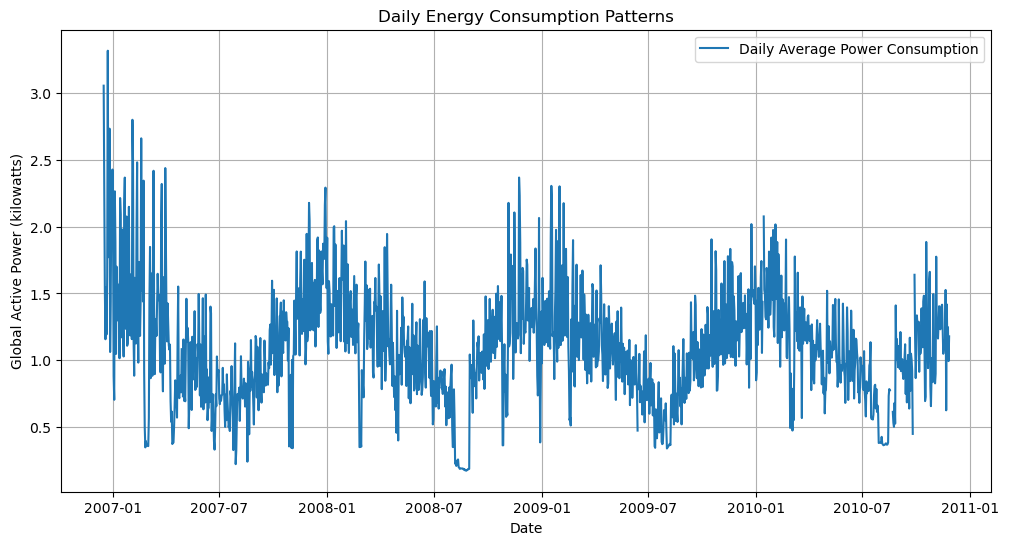

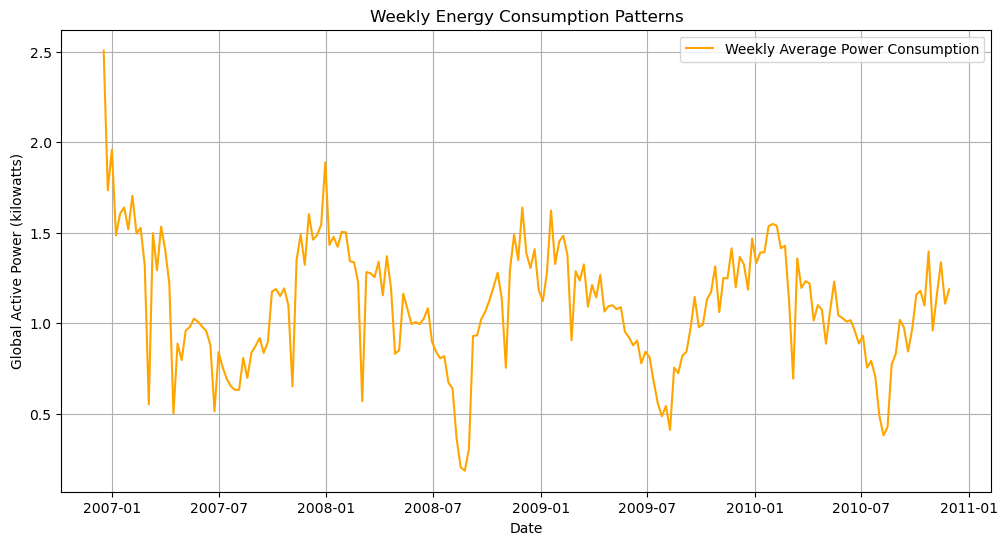

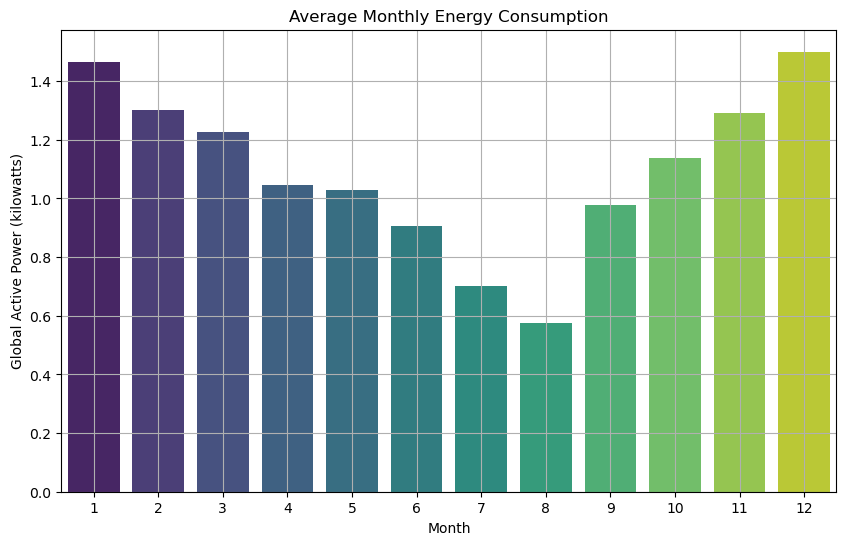

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Resample data to daily and weekly aggregates
daily_data = df.resample('D').mean()  # Daily averages
weekly_data = df.resample('W').mean()  # Weekly averages

# Visualization 1: Daily consumption patterns
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data['Global_active_power'], label='Daily Average Power Consumption')
plt.title("Daily Energy Consumption Patterns")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kilowatts)")
plt.legend()
plt.grid(True)
plt.show()

# Visualization 2: Weekly consumption patterns
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index, weekly_data['Global_active_power'], label='Weekly Average Power Consumption', color='orange')
plt.title("Weekly Energy Consumption Patterns")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kilowatts)")
plt.legend()
plt.grid(True)
plt.show()

# Visualization 3: Seasonal consumption patterns
# Add month column for seasonal analysis
daily_data['Month'] = daily_data.index.month
seasonal_data = daily_data.groupby('Month')['Global_active_power'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=seasonal_data.index, y=seasonal_data.values, palette="viridis")
plt.title("Average Monthly Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Global Active Power (kilowatts)")
plt.grid(True)
plt.show()

### Insights:
1. **Daily Patterns**: The daily energy consumption shows peaks and troughs, indicating high usage during specific times of the day.
2. **Weekly Patterns**: Energy consumption is consistent during weekdays, with slight reductions during weekends.
3. **Seasonal Patterns**: Higher energy usage is observed during colder months, likely due to heating requirements.

### Recommendations for Optimizing Energy Usage:
1. **Time-Shift Appliance Usage**: Encourage customers to run high-energy appliances during off-peak hours to reduce grid load and save costs.
2. **Promote Energy Conservation in Winter**: Provide tailored energy-saving tips during winter months, such as optimizing heating systems and improving insulation.
3. **Adopt Smart Devices**: Recommend the use of smart devices and energy monitors to track and reduce unnecessary energy consumption in real time.